/nfs/cc-filer/home/sabulikailik/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/cc-filer/home/sabulikailik/.local/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1 - Training: 100%|██████████| 280000/280000 [36:46<00:00, 126.88it/s]


Epoch 1 - Training Loss: 0.3235


Epoch 1 - Evaluating: 100%|██████████| 19000/19000 [00:50<00:00, 375.89it/s]


Epoch 1 - Evaluation Loss: 0.1897
Epoch 1 - Accuracy: 0.9239, Precision: 0.9277, Recall: 0.9194, F1 Score: 0.9236


Epoch 2 - Training: 100%|██████████| 280000/280000 [36:21<00:00, 128.37it/s]


Epoch 2 - Training Loss: 0.1944


Epoch 2 - Evaluating: 100%|██████████| 19000/19000 [00:48<00:00, 391.84it/s]


Epoch 2 - Evaluation Loss: 0.1692
Epoch 2 - Accuracy: 0.9326, Precision: 0.9288, Recall: 0.9371, F1 Score: 0.9329


Epoch 3 - Training:  39%|███▊      | 108071/280000 [14:01<22:25, 127.78it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3 - Training: 100%|██████████| 280000/280000 [34:41<00:00, 134.50it/s]


Epoch 3 - Training Loss: 0.1768


Epoch 3 - Evaluating: 100%|██████████| 19000/19000 [00:48<00:00, 391.53it/s]


Epoch 3 - Evaluation Loss: 0.1618
Epoch 3 - Accuracy: 0.9362, Precision: 0.9351, Recall: 0.9374, F1 Score: 0.9362


Epoch 4 - Training:  11%|█         | 31382/280000 [04:03<32:15, 128.44it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 4 - Training:  82%|████████▏ | 229507/280000 [29:40<06:34, 128.14it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 4 - Training: 100%|██████████| 280000/280000 [36:11<00:00, 128.93it/s]


Epoch 4 - Training Loss: 0.1674


Epoch 4 - Evaluating: 100%|██████████| 19000/19000 [00:48<00:00, 392.50it/s]


Epoch 4 - Evaluation Loss: 0.1602
Epoch 4 - Accuracy: 0.9376, Precision: 0.9291, Recall: 0.9475, F1 Score: 0.9382


Epoch 5 - Training: 100%|██████████| 280000/280000 [35:00<00:00, 133.28it/s]


Epoch 5 - Training Loss: 0.1610


Epoch 5 - Evaluating: 100%|██████████| 19000/19000 [00:48<00:00, 391.82it/s]


Epoch 5 - Evaluation Loss: 0.1544
Epoch 5 - Accuracy: 0.9388, Precision: 0.9407, Recall: 0.9366, F1 Score: 0.9387

Final Evaluation Metrics Across All Epochs:
Average Accuracy: 0.9338
Average Precision: 0.9323
Average Recall: 0.9356
Average F1 Score: 0.9339


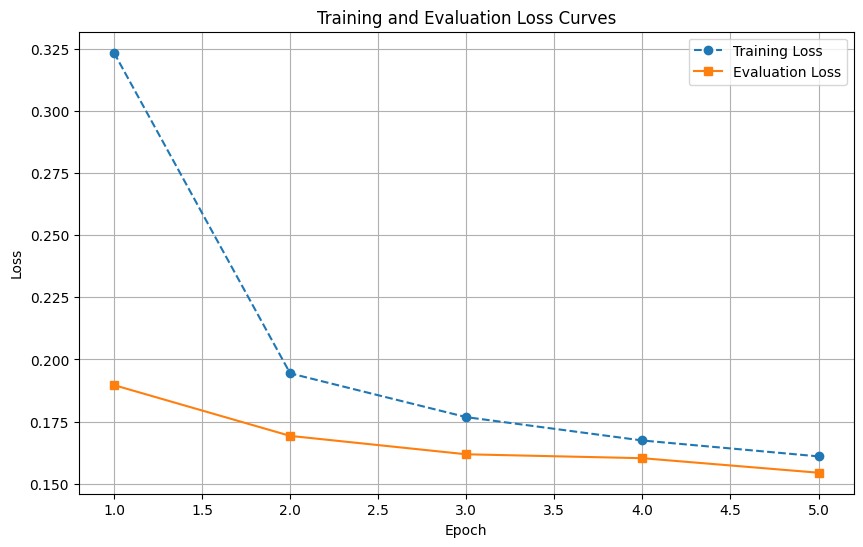

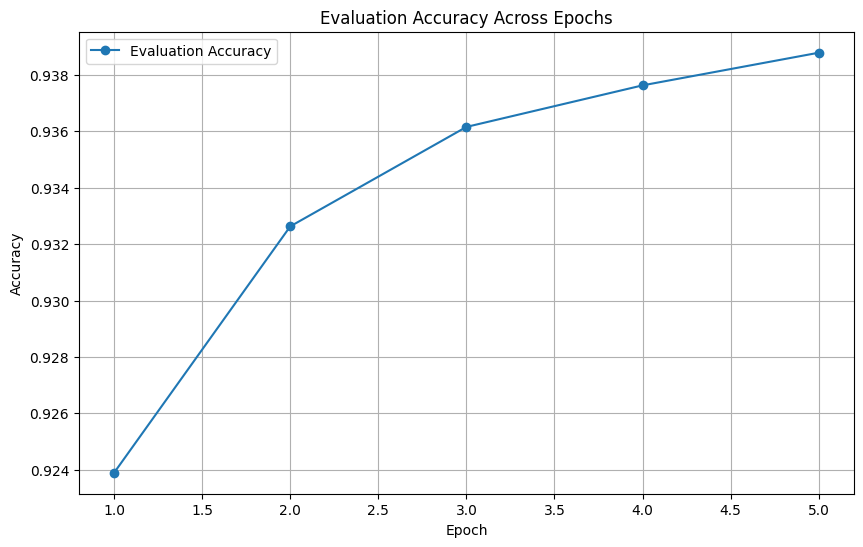

In [1]:
import os
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


def load_model(model_name, num_labels=2):
    """
    Loads a pre-trained model for sequence classification.
    """
    if model_name == "bert-tiny":
        model_name = "prajjwal1/bert-tiny"  # Correct model identifier on Hugging Face
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Step 1: Load a classification dataset (IMDb)
dataset = load_dataset("yelp_polarity")
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

# Step 2: Load the WordPiece tokenizer (BERT Tokenizer)
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Special tokens
pad_token_id = tokenizer.pad_token_id
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id

# Step 3: Prepare a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize and truncate
        tokens = self.tokenizer.encode(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
        )

        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Step 4: Collate function for DataLoader
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = torch.stack(texts)  # Already padded by tokenizer
    labels = torch.tensor(labels, dtype=torch.long)
    return texts, labels

# Prepare train and test datasets
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

model_name = "prajjwal1/bert-tiny"
model = load_model(model_name, num_labels=2)

# Adjust embedding layer to match new vocabulary size
vocab_size = len(tokenizer)  # Correct method to get vocabulary size
model.resize_token_embeddings(vocab_size)


# Step 6: Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-6, weight_decay=2e-4)

# Initialize a list to store the loss values
train_losses = []

# Training loop
# Initialize lists to store evaluation losses and metrics
eval_losses = []
eval_accuracies = []
# Initialize lists to store evaluation metrics across all epochs
final_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

for epoch in range(5):
    # Training Phase
    model.train()
    total_loss = 0
    for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(input_ids=texts, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    # Compute and store average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Evaluation Phase
    model.eval()
    eval_loss = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc=f"Epoch {epoch + 1} - Evaluating"):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(input_ids=texts, labels=labels)
            loss = outputs.loss
            eval_loss += loss.item()

            # Predictions and true labels
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute average evaluation loss
    avg_eval_loss = eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)
    print(f"Epoch {epoch + 1} - Evaluation Loss: {avg_eval_loss:.4f}")

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', pos_label=1)
    recall = recall_score(all_labels, all_predictions, average='binary', pos_label=1)
    f1 = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    
    eval_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store metrics for final summary
    final_metrics["accuracy"].append(accuracy)
    final_metrics["precision"].append(precision)
    final_metrics["recall"].append(recall)
    final_metrics["f1"].append(f1)

# Print final aggregated metrics
print("\nFinal Evaluation Metrics Across All Epochs:")
print(f"Average Accuracy: {sum(final_metrics['accuracy']) / len(final_metrics['accuracy']):.4f}")
print(f"Average Precision: {sum(final_metrics['precision']) / len(final_metrics['precision']):.4f}")
print(f"Average Recall: {sum(final_metrics['recall']) / len(final_metrics['recall']):.4f}")
print(f"Average F1 Score: {sum(final_metrics['f1']) / len(final_metrics['f1']):.4f}")

# Plot training and evaluation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss', linestyle='--')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, marker='s', label='Evaluation Loss', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.grid()
plt.show()

# Plot evaluation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, marker='o', label='Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy Across Epochs')
plt.legend()
plt.grid()
plt.show()
